# <a style = background:lightgreen;color:black>Settlement Prediction on train_s (modeling) </a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('../DATA/final_train_s_dummies.csv')

In [3]:
X = data[['Tax Related', 'Number of Lawyers',
     'Number of Legal Parties', 'Value formatted',
       'Unified Contribution formatted', 'Milano', 'Bari', 'Bologna', 'Genova',
       'Palermo', 'Napoli', 'Torino', 'Trento', 'Roma', "L'Aquila", 'Potenza',
       'Perugia', 'Campobasso', 'Firenze', 'Cagliari', 'Venezia', 'Cosenza',
       'Ancona', 'Trieste', 'Aosta','OR-140999', 'OR-145009', 'OR-139999',
       'OR-145999', 'OR-130099', 'OR-101003', 'OR-130121', 'OR-130111',
       'OR-130131', 'OR-101002', 'OR-180002', 'OSA-180002']]
y=data['Settlement']

## <a style=background:yellow;color:black> Standardization and Split in training, validation and testing set </a>

You need to scale just the variables that are neither dummies nor boolean.

In [4]:
X_to_scale = X[['Number of Lawyers','Number of Legal Parties', 'Value formatted',
       'Unified Contribution formatted']]
X_not_to_scale = X[['Tax Related','Milano', 'Bari', 'Bologna', 'Genova',
       'Palermo', 'Napoli', 'Torino', 'Trento', 'Roma', "L'Aquila", 'Potenza',
       'Perugia', 'Campobasso', 'Firenze', 'Cagliari', 'Venezia', 'Cosenza',
       'Ancona', 'Trieste', 'Aosta','OR-140999', 'OR-145009', 'OR-139999',
       'OR-145999', 'OR-130099', 'OR-101003', 'OR-130121', 'OR-130111',
       'OR-130131', 'OR-101002', 'OR-180002', 'OSA-180002']]

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

y = pd.DataFrame(y)
std_scale = StandardScaler()
X_scaled = std_scale.fit_transform(X_to_scale)

In [6]:
X_scaled_df = pd.DataFrame(X_scaled, columns=[X_to_scale.columns])
X_scaled_df = pd.concat([X_scaled_df, X_not_to_scale], axis=1)

In [7]:
new_var_names = []
for var_name in X_scaled_df.columns:
    if '(' not in var_name:
        new_var_names.append(var_name)
    else:
        new_var_names.append(var_name.replace('(', '').replace(')', '')
        .replace('\'','').replace(',','').replace('"',''))
new_var_names = []
for var_name in X_scaled_df.columns:
    if type(var_name) != tuple:
        new_var_names.append(var_name)
    else:
        new_var_names.append(var_name[0])

X_scaled_df = pd.DataFrame(X_scaled_df.values, columns=new_var_names)

In [8]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled_df, y, random_state=0,
                                                            test_size=0.1)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,random_state=0,
                                                            test_size=0.2  )

## <a style=background:yellow;color:black id='reg_tree'> REGRESSION-TREE</a>

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

In [12]:
reg_tree = DecisionTreeRegressor(random_state=42, criterion='absolute_error',
                                min_samples_split=10,
                                max_features='sqrt')

reg_tree.fit(X_train_val,y_train_val)

DecisionTreeRegressor(criterion='absolute_error', max_features='sqrt',
                      min_samples_split=10, random_state=42)

In [15]:
from sklearn.metrics import mean_absolute_error
y_pred = reg_tree.predict(X_test)
residuals = np.ravel(np.array(y_pred)) - np.ravel(np.array(y_test))

pd.DataFrame({'y_true':np.ravel(y_test), 'y_pred':np.ravel(y_pred), 'residuals':np.ravel(residuals)})

,y_true,y_pred,residuals
0,971.67,600.00,-371.67
1,409.63,464.00,54.37
2,7290.49,11659.89,4369.40
3,1.00,3913.24,3912.24
4,1082.64,1777.23,694.59
...,...,...,...
9655,752.05,600.00,-152.05
9656,314.39,317.00,2.61
9657,500.00,1052.00,552.00
9658,135.43,750.00,614.57


In [14]:
print(mean_absolute_error(y_test, y_pred))

867.1266563146997


## <a style=background:yellow;color:black> MARS (Check the R Script)</a>

* One major problem with trees is their high variance. Often a small change in the data can result in a very different series of splits. This is due to the hierarchical nature of the process (if an error occurs in the first split, then all the other splits can just make it worse and worse). A way to reduce this variance is to use Bagging (We've done it with Random Forest).
* The lack of smoothness of the predictions surfaces and the difficulty in capturing additive structure can be a problem for regression tasks. We can solve this problems by using <a style=color:deepskyblue> **MARS** </a> (Multivariate Additive Regression Splines).

In [ ]:
# # This chunk is for the MARS model.
# final_train_s_dummies_std = pd.concat([X_test, X_train_val],axis=0 )
# final_train_s_dummies_std['Settlement'] = pd.concat([y_test, y_train_val], axis = 0)
# final_train_s_dummies_std.to_excel('final_train_s_dummies_std.xlsx')

## <a style=background:yellow;color:black id='Random_Forest'> Random Forest </a>

In [23]:
from sklearn.ensemble import RandomForestRegressor

rnd_reg = RandomForestRegressor(n_estimators=50,
                                #n_jobs=5,
                                max_depth=10,
                                criterion='absolute_error',
                               random_state = 42,
                               min_samples_split=20,
                               min_samples_leaf=20,
                               max_leaf_nodes=None)

In [24]:
rnd_reg.fit(X_train_val, np.array(y_train_val).ravel())

In [ ]:
y_pred = rnd_reg.predict(X_test)

residuals = np.array(y_pred) - np.array(y_test)

print(mean_absolute_error(y_test, y_pred))
print(mean_absolute_error(y_train_val, rnd_reg.predict(X_train_val)))

765.0234303933746
727.9669157159126


In [ ]:
import joblib

# joblib.dumb(rnd_red, '../models/random_forest_train_s.sav')
# rnd_reg = joblib.load('../models/random_forest_train_s.sav')

Let's destandardize X_train_val and X_test (the reason why we do it is that we want to build a dataset (data_for_plotting.csv) in order to see the results of the models in Tableau considering the original scale of the variables).

In [ ]:
X_train_val_inv_trans = pd.DataFrame(std_scale.inverse_transform(X_train_val[['Number of Lawyers','Number of Legal Parties', 'Value formatted',
       'Unified Contribution formatted']]), columns = ['Number of Lawyers','Number of Legal Parties', 'Value formatted',
       'Unified Contribution formatted'], index = X_train_val.index)

X_test_inv_trans = pd.DataFrame(std_scale.inverse_transform(X_test[['Number of Lawyers','Number of Legal Parties', 'Value formatted',
       'Unified Contribution formatted']]), columns = ['Number of Lawyers','Number of Legal Parties', 'Value formatted',
       'Unified Contribution formatted'], index=X_test.index)

X_train_val_not_std = X_train_val[['Tax Related','Milano', 'Bari', 'Bologna', 'Genova',
       'Palermo', 'Napoli', 'Torino', 'Trento', 'Roma', "L'Aquila", 'Potenza',
       'Perugia', 'Campobasso', 'Firenze', 'Cagliari', 'Venezia', 'Cosenza',
       'Ancona', 'Trieste', 'Aosta','OR-140999', 'OR-145009', 'OR-139999',
       'OR-145999', 'OR-130099', 'OR-101003', 'OR-130121', 'OR-130111',
       'OR-130131', 'OR-101002', 'OR-180002', 'OSA-180002']]

X_test_not_std = X_test[['Tax Related','Milano', 'Bari', 'Bologna', 'Genova',
       'Palermo', 'Napoli', 'Torino', 'Trento', 'Roma', "L'Aquila", 'Potenza',
       'Perugia', 'Campobasso', 'Firenze', 'Cagliari', 'Venezia', 'Cosenza',
       'Ancona', 'Trieste', 'Aosta','OR-140999', 'OR-145009', 'OR-139999',
       'OR-145999', 'OR-130099', 'OR-101003', 'OR-130121', 'OR-130111',
       'OR-130131', 'OR-101002', 'OR-180002', 'OSA-180002']]

X_train_val_destandardized = pd.concat([X_train_val_inv_trans, X_train_val_not_std],axis=1)
X_test_destandardized = pd.concat([X_test_inv_trans, X_test_not_std],axis=1)

X_train_val_destandardized = pd.DataFrame(np.array(X_train_val_destandardized), columns=[['Number of Lawyers',
     'Number of Legal Parties', 'Value formatted',
       'Unified Contribution formatted', 'Tax Related','Milano', 'Bari', 'Bologna', 'Genova',
       'Palermo', 'Napoli', 'Torino', 'Trento', 'Roma', "L'Aquila", 'Potenza',
       'Perugia', 'Campobasso', 'Firenze', 'Cagliari', 'Venezia', 'Cosenza',
       'Ancona', 'Trieste', 'Aosta','OR-140999', 'OR-145009', 'OR-139999',
       'OR-145999', 'OR-130099', 'OR-101003', 'OR-130121', 'OR-130111',
       'OR-130131', 'OR-101002', 'OR-180002', 'OSA-180002']], index = X_train_val_destandardized.index)

X_test_destandardized = pd.DataFrame(np.array(X_test_destandardized), columns=[['Number of Lawyers',
     'Number of Legal Parties', 'Value formatted',
       'Unified Contribution formatted', 'Tax Related','Milano', 'Bari', 'Bologna', 'Genova',
       'Palermo', 'Napoli', 'Torino', 'Trento', 'Roma', "L'Aquila", 'Potenza',
       'Perugia', 'Campobasso', 'Firenze', 'Cagliari', 'Venezia', 'Cosenza',
       'Ancona', 'Trieste', 'Aosta','OR-140999', 'OR-145009', 'OR-139999',
       'OR-145999', 'OR-130099', 'OR-101003', 'OR-130121', 'OR-130111',
       'OR-130131', 'OR-101002', 'OR-180002', 'OSA-180002']], index = X_test_destandardized.index)

In [ ]:
# y_pred_MARS = np.array(pd.read_excel('y_pred.xlsx')).ravel()

# data_for_plotting = pd.DataFrame({'y_true':np.concatenate([np.array(y_test),np.array(y_train_val)]).ravel(),
#  'y_pred_rnd_for_no_grid':np.concatenate([np.array(rnd_reg.predict(X_test)),np.array(rnd_reg.predict(X_train_val))]),
# 'y_pred_MARS':y_pred_MARS,
#  'Value formatted':np.array(pd.concat([X_test_destandardized['Value formatted'], X_train_val_destandardized['Value formatted']], axis=0)).ravel(),
#  'Unified contribution formatted':np.array(pd.concat([X_test_destandardized['Unified Contribution formatted'], X_train_val_destandardized['Unified Contribution formatted']], axis=0)).ravel(),
# 'train_test':np.concatenate([np.repeat('test',y_test.shape[0]),np.repeat('train',y_train_val.shape[0])])})

# data_for_plotting.to_csv('data_for_plotting.csv')

## <a style=background:yellow;color:black id='xgboost'> XGBoost</a>

In [25]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

In [70]:
params = {
    'booster': 'gbtree',
    'learning_rate': 0.05,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'eta': 0.01,
    'subsample': 0.8,
    'colsample_bytree': 0.5,
    'tree_method': 'exact',
    'verbosity': 0,
    'max_depth': 10,
}

# Define the dataset for xgboost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# # Define the learning rate schedule
# def learning_rate_schedule(iteration):
#     if iteration < 100:
#         return 0.1
#     elif 100 <= iteration < 200:
#         return 0.01
#     else:
#         return 0.001

# # Define the callback to update the learning rate
# def update_learning_rate(env):
#     lr = learning_rate_schedule(env.iteration)
#     env.model.params['learning_rate'] = lr

# Define the stopping criteria
early_stopping_rounds = 50

# Train the model with early stopping
# model = xgb.train(params, dtrain, num_boost_round=500, evals=[(dval, 'val')], early_stopping_rounds=early_stopping_rounds, verbose_eval=False, callbacks=[update_learning_rate])
model = xgb.train(params, dtrain, num_boost_round=1000, evals=[(dval, 'val')], early_stopping_rounds=early_stopping_rounds, verbose_eval=False)


In [72]:
# model.save_model("../models/xgb_train_s.model")

In [73]:
# xgb_model = xgb.Booster()
# xgb_model.load_model('../models/xgb_train_s.model')

dtest = xgb.DMatrix(X_test)
y_pred_test = model.predict(dtest)
print(mean_absolute_error(y_pred_test,y_test))

805.6419785217511


In [75]:
# data_for_plotting = pd.read_csv('../DATA/data_for_plotting.csv')
# dtrain_val = xgb.DMatrix(X_train_val)
# data_for_plotting['y_pred_xgb'] = np.concatenate([np.array(model.predict(dtest)),np.array(model.predict(dtrain_val))])
# data_for_plotting.to_csv('../DATA/data_for_plotting.csv')
# data_for_plotting = pd.read_csv('../DATA/data_for_plotting.csv')
# data_for_plotting.to_excel('../DATA/data_for_plotting.xlsx')

## <a style=background:yellow;color:black id='neural_network'> Neural Network </a>

In [11]:
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.metrics import mean_absolute_error

The following chunk is for reproducibility purposes. It is not necessary to run it. Moreover, keras.backend.clear_session() is useful in cases where you want to start a new session with a fresh set of variables, or if you want to clear the session to free up memory.

In [12]:
tf.random.set_seed(42)
keras.backend.clear_session() 
np.random.seed(42)

In the following chunk we have the learning rate scheduler of the neural network (for the first 3 epochs it is equal to the lr defined in the .compile() method and afterwords at each epoch it decreases of lr*exp(-0.025)). Moreover there is an early stopping callback and a tensorboard callback. The tensorboard callback is used to visualize the training process in Tensorboard. The early stopping callback is used to stop the training process when the validation loss doesn't decrease for 10 epochs. The get_run_logdir function is used to create a unique subdirectory in which to save the Tensorboard log files for each training run. This is necessary to avoid problems when you launch multiple Tensorboard instances at the same time.

The histogram_freq parameter in the TensorBoard callback of Keras determines how often (in number of epochs) to compute activation and weight histograms for the layers of the model. If set to 1, histograms will be computed after every epoch. If set to 0, histograms will not be computed. If set to a value greater than 1, histograms will be computed every histogram_freq epochs.

In [13]:
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.025)

def get_run_logdir(root_logdir, model_name):
    import time
    run_id = time.strftime('run_%Y_%m_%d-%H_%M_%S')
    return os.path.join(root_logdir, model_name+'_'+run_id)

model_name = input('Enter model name: ')
root_logdir = os.path.join(os.curdir,'..', 'my_logs')
run_logdir = get_run_logdir(root_logdir, model_name)

lr_schedule_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir,
                                            histogram_freq=1)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal",input_shape=X_train.shape[1:]),
    keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal"),
    keras.layers.Dense(64, activation='relu', kernel_initializer="he_normal"),
    keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dense(1)
])

model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=0.015))

In [ ]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),callbacks=[tensorboard_cb, lr_schedule_cb, early_stop_cb])

In [22]:
# model.save('../models/NeuralNet_train_s.h5')

In [ ]:
!tensorboard --logdir=../my_logs --port=6006

In [ ]:
mean_absolute_error(y_test, model.predict(X_test))

In [ ]:
# data_for_plotting = pd.read_excel('data_for_plotting.xlsx')
# data_for_plotting['y_pred_neural_network_oversamp'] = np.concatenate([np.array(model.predict(X_test)),np.array(model.predict(X_train_val))])
# data_for_plotting.to_excel('data_for_plotting.xlsx')

### <a style=background:lightgreen;color:black> Neural Network with Pytorch </a>

In [103]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RegressioNet(nn.Module):
    def __init__(self, input_dim, hidden_dims_vector, output_dim):
        super(RegressioNet, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims_vector = hidden_dims_vector
        self.output_dim = output_dim
        self.fc1 = nn.Linear(self.input_dim, self.hidden_dims_vector[0])
        self.fc2 = nn.Linear(self.hidden_dims_vector[0], self.hidden_dims_vector[1])
        self.fc3 = nn.Linear(self.hidden_dims_vector[1], self.hidden_dims_vector[2])
        self.fc4 = nn.Linear(self.hidden_dims_vector[2], self.hidden_dims_vector[3])
        self.fc5 = nn.Linear(self.hidden_dims_vector[3], self.output_dim)
        self.batch_norm = nn.BatchNorm1d(self.hidden_dims_vector[0])
        self.criterion = nn.L1Loss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, factor=0.1, patience=5)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x
    
    def fit(self, X_train, y_train, X_val, y_val, epochs, batch_size, patience):
        self.train()
        best_val_loss = float('inf')
        counter_patience = 0
        best_model_state = None
        for epoch in range(epochs):
            running_loss_train = 0
            for i in range(0, X_train.shape[0], batch_size):
                self.optimizer.zero_grad()
                X_train_batch = X_train[i:i+batch_size]
                y_train_batch = y_train[i:i+batch_size]
                y_train_pred = self.forward(X_train_batch)
                loss_train = self.criterion(y_train_pred, y_train_batch)
                loss_train.backward()
                running_loss_train += loss_train * X_train_batch.size(0)
                self.optimizer.step()
            epoch_loss = running_loss_train / X_train.shape[0]
            self.scheduler.step(epoch_loss)

            self.eval()
            with torch.no_grad():
                y_val_pred = self.forward(X_val)
                loss_val = self.criterion(y_val_pred, y_val)
            
                if loss_val < best_val_loss:
                    best_val_loss = loss_val
                    counter_patience = 0
                    best_model_state = self.state_dict()
                else:
                    counter_patience += 1

            if counter_patience >= patience:
                print(f"Stopping early after {epoch+1} epochs with best validation loss of {best_val_loss:.4f}")
                self.load_state_dict(best_model_state)
                return self
            
            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1}, train loss: {epoch_loss:.4f}, val loss: {loss_val:.4f}")
        
        self.load_state_dict(best_model_state)
        return self
    
    def predict(self, X):
        self.eval()
        with torch.no_grad():
            y_pred = self.forward(X)
        return y_pred
         

In [104]:
torch_nn_model = RegressioNet(input_dim=X_train.shape[1], hidden_dims_vector=[64, 128, 64, 30], output_dim=1)

In [94]:
X_train_tensor = torch.Tensor(X_train.to_numpy())
y_train_tensor = torch.Tensor(y_train.to_numpy())
X_val_tensor = torch.Tensor(X_val.to_numpy())
y_val_tensor = torch.Tensor(y_val.to_numpy())

In [105]:
torch_nn_model.fit(X_train_tensor, y_train_tensor,X_val_tensor,y_val_tensor, epochs=300, batch_size=32, patience = 20)

Epoch 5, train loss: 799.5844, val loss: 771.1795
Epoch 10, train loss: 773.7317, val loss: 760.5770
Epoch 15, train loss: 755.6249, val loss: 752.5309
Epoch 20, train loss: 748.3757, val loss: 749.5948
Epoch 25, train loss: 743.9448, val loss: 749.1926
Epoch 30, train loss: 740.8941, val loss: 748.3987
Epoch 35, train loss: 737.5598, val loss: 745.8500
Epoch 40, train loss: 734.2260, val loss: 742.1061
Epoch 45, train loss: 732.2869, val loss: 741.0244
Epoch 50, train loss: 729.4374, val loss: 739.9911
Epoch 55, train loss: 727.6086, val loss: 741.5348
Epoch 60, train loss: 725.3690, val loss: 740.0701
Epoch 65, train loss: 724.2121, val loss: 738.1782
Epoch 70, train loss: 722.4235, val loss: 738.5695
Epoch 75, train loss: 721.1548, val loss: 736.5424
Epoch 80, train loss: 719.6270, val loss: 739.5966
Epoch 85, train loss: 717.4664, val loss: 743.9574
Epoch 90, train loss: 716.5593, val loss: 738.9031
Stopping early after 95 epochs with best validation loss of 736.5424


RegressioNet(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=30, bias=True)
  (fc5): Linear(in_features=30, out_features=1, bias=True)
  (batch_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (criterion): L1Loss()
)

In [106]:
X_test_tensor = torch.Tensor(X_test.to_numpy())
y_test_tensor = torch.Tensor(y_test.to_numpy())

with torch.no_grad():
    y_pred = torch_nn_model.predict(X_test_tensor)
    test_loss = nn.L1Loss()(y_pred, y_test_tensor)

print(test_loss)

tensor(764.8514)


## <a style=background:yellow;color:black> Downsampling and Upsampling </a>

In this chapter we are going to try to solve the unbalance problem with downsampling and upsampling.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('../DATA/final_train_s_dummies.csv')

X_y = data[['Tax Related', 'Number of Lawyers',
     'Number of Legal Parties', 'Value formatted',
       'Unified Contribution formatted', 'Milano', 'Bari', 'Bologna', 'Genova',
       'Palermo', 'Napoli', 'Torino', 'Trento', 'Roma', "L'Aquila", 'Potenza',
       'Perugia', 'Campobasso', 'Firenze', 'Cagliari', 'Venezia', 'Cosenza',
       'Ancona', 'Trieste', 'Aosta','OR-140999', 'OR-145009', 'OR-139999',
       'OR-145999', 'OR-130099', 'OR-101003', 'OR-130121', 'OR-130111',
       'OR-130131', 'OR-101002', 'OR-180002', 'OSA-180002', 'Settlement']]



In [ ]:
# This chunk takes about 20 seconds to run
ranges_value = []
for i in range(X_y.shape[0]):
    if (X_y.iloc[i]['Value formatted'] >= 0) & (X_y.iloc[i]['Value formatted'] < 1) :
         ranges_value.append('[0-1)')
    elif (X_y.iloc[i]['Value formatted'] >= 1) & (X_y.iloc[i]['Value formatted'] <= 1000) :
         ranges_value.append('[1,1000]')
    elif (X_y.iloc[i]['Value formatted'] > 1000) & (X_y.iloc[i]['Value formatted'] <= 1100) :
         ranges_value.append('(1000,1100]')
    elif (X_y.iloc[i]['Value formatted'] > 1100) & (X_y.iloc[i]['Value formatted'] <= 5200) :
         ranges_value.append('(1100,5200]')
    elif (X_y.iloc[i]['Value formatted'] > 5200) & (X_y.iloc[i]['Value formatted'] <= 26000) :
         ranges_value.append('(5200,26000]')
    elif (X_y.iloc[i]['Value formatted'] > 26000) & (X_y.iloc[i]['Value formatted'] <= 52000) :
         ranges_value.append('(26000,52000]')
    elif (X_y.iloc[i]['Value formatted'] > 52000) & (X_y.iloc[i]['Value formatted'] <= 260000) :
         ranges_value.append('(52000,260000]')
    elif (X_y.iloc[i]['Value formatted'] > 260000) & (X_y.iloc[i]['Value formatted'] <= 520000) :
         ranges_value.append('(260000,520000]')
    elif (X_y.iloc[i]['Value formatted'] > 520000):
         ranges_value.append('(520000,inf)')
    else:
        ranges_value.append('error')

X_y['ranges_value']=ranges_value


In [4]:
X_y.groupby(['ranges_value']).size()

ranges_value
(1000,1100]        5369
(1100,5200]       48556
(26000,52000]        61
(5200,26000]       9539
(52000,260000]        8
(520000,inf)          2
[0-1)               748
[1,1000]          32308
dtype: int64

In [5]:
y = X_y['Settlement']

X_y.drop(['Settlement'], axis=1, inplace=True)

X_to_scale = X_y[['Number of Lawyers','Number of Legal Parties', 'Value formatted',
       'Unified Contribution formatted']]

X_not_to_scale = X_y[['Tax Related','Milano', 'Bari', 'Bologna', 'Genova',
       'Palermo', 'Napoli', 'Torino', 'Trento', 'Roma', "L'Aquila", 'Potenza',
       'Perugia', 'Campobasso', 'Firenze', 'Cagliari', 'Venezia', 'Cosenza',
       'Ancona', 'Trieste', 'Aosta','OR-140999', 'OR-145009', 'OR-139999',
       'OR-145999', 'OR-130099', 'OR-101003', 'OR-130121', 'OR-130111',
       'OR-130131', 'OR-101002', 'OR-180002', 'OSA-180002', 'ranges_value']]


y = pd.DataFrame(y)
std_scale = StandardScaler()
X_scaled = std_scale.fit_transform(X_to_scale)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_to_scale.columns)
X_scaled_df = pd.concat([X_scaled_df, X_not_to_scale], axis=1)
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled_df, y, random_state=0,
                                                            test_size=0.1)
X_test.drop(['ranges_value'], axis=1, inplace=True)
X_y_train_val = pd.concat([X_train_val,y_train_val],axis=1)


/var/folders/j3/6zzd1jr16pb3yxx70_376pmw0000gn/T/ipykernel_6407/3290639181.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_y.drop(['Settlement'], axis=1, inplace=True)


In the following chunk we're going to:

*  build a downsampled dataset (the four classes with the highest number of observations will be downsampled to 4831 that is the number of observations of the class with less observations among them);
* build an upsampled dataset (the (5200, 26000] class will be upsampled to 29000 observations). The reason is that for this class we have the highest MAE considering the number of observations per class.

In [ ]:
downsampled_df = pd.DataFrame(columns=X_y_train_val.columns)
upsampled_df = pd.DataFrame(columns=X_y_train_val.columns)

for i in X_y_train_val['ranges_value'].unique():
    if i in ['[1,1000]','(1000,1100]','(1100,5200]']:
        downsampled_df = downsampled_df.append(X_y_train_val[X_y_train_val['ranges_value']==i].sample(4831, replace=True))
        upsampled_df = upsampled_df.append(X_y_train_val[X_y_train_val['ranges_value']==i])
    elif i == '(5200,26000]':
        downsampled_df = downsampled_df.append(X_y_train_val[X_y_train_val['ranges_value']==i].sample(4831, replace=True))
        upsampled_df = upsampled_df.append(X_y_train_val[X_y_train_val['ranges_value']==i].sample(29000, replace=True))
    else:
        downsampled_df = downsampled_df.append(X_y_train_val[X_y_train_val['ranges_value']==i])
        upsampled_df = upsampled_df.append(X_y_train_val[X_y_train_val['ranges_value']==i])

In the following chunk we have the learning rate scheduler of the neural network (for the first 3 epochs it is equal to the lr defined in the .compile and afterwords at each epoch it decreases of lr*exp(-0.025)). Moreover there is an early stopping callback and a tensorboard callback. The tensorboard callback is used to visualize the training process in Tensorboard. The early stopping callback is used to stop the training process when the validation loss doesn't decrease for 10 epochs. The get_run_logdir function is used to create a unique subdirectory in which to save the Tensorboard log files for each training run. This is necessary to avoid problems when you launch multiple Tensorboard instances at the same time.

In [7]:
columns_to_convert = ['Tax Related', 'Milano', 'Bari',
       'Bologna', 'Genova', 'Palermo', 'Napoli', 'Torino', 'Trento', 'Roma',
       "L'Aquila", 'Potenza', 'Perugia', 'Campobasso', 'Firenze', 'Cagliari',
       'Venezia', 'Cosenza', 'Ancona', 'Trieste', 'Aosta', 'OR-140999',
       'OR-145009', 'OR-139999', 'OR-145999', 'OR-130099', 'OR-101003',
       'OR-130121', 'OR-130111', 'OR-130131', 'OR-101002', 'OR-180002',
       'OSA-180002']

for column in columns_to_convert:
    downsampled_df[column] = downsampled_df[column].astype('int64')
    upsampled_df[column] = upsampled_df[column].astype('int64')

The following chunk builds and fit a neural network on the downsampled dataset.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Set random seed and clear the session
tf.random.set_seed(42)
keras.backend.clear_session()

# Callbacks
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.025)

def get_run_logdir(root_logdir, model_name):
    import time
    run_id = time.strftime('run_%Y_%m_%d-%H_%M_%S')
    return os.path.join(root_logdir, model_name+'_'+run_id)

model_name = input('Enter model name: ')
root_logdir = os.path.join(os.curdir,'..', 'my_logs')
run_logdir = get_run_logdir(root_logdir, model_name)

lr_schedule_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir,
                                            histogram_freq=1)

# Model design
model1 = keras.models.Sequential([
    keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal",input_shape=(37,)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal"),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(64, activation='relu', kernel_initializer="he_normal"),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dense(1)
])

model1.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=0.015))

# Split in train and validation set
train_downsampled, val_downsampled = train_test_split(downsampled_df, test_size=0.2, random_state=42)

# Fitting
history = model1.fit(train_downsampled.drop(columns=['Settlement','ranges_value']),
                     train_downsampled['Settlement'],
                      epochs=100,
                       validation_data=(val_downsampled.drop(columns=['Settlement','ranges_value']),
                        val_downsampled['Settlement']),
                       callbacks=[tensorboard_cb, lr_schedule_cb, early_stop_cb])

# MAE on the test set
mean_absolute_error(y_test, model1.predict(X_test))

The following chunk builds and fit a neural network on the upsampled dataset.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Set random seed and clear the session
tf.random.set_seed(42)
keras.backend.clear_session()

# Callbacks
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.025)

def get_run_logdir(root_logdir, model_name):
    import time
    run_id = time.strftime('run_%Y_%m_%d-%H_%M_%S')
    return os.path.join(root_logdir, model_name+'_'+run_id)

model_name = input('Enter model name: ')
root_logdir = os.path.join(os.curdir,'..', 'my_logs')
run_logdir = get_run_logdir(root_logdir, model_name)

lr_schedule_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir,
                                            histogram_freq=1)

# Model design
model = keras.models.Sequential([
    keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal",input_shape=(37,)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal"),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(64, activation='relu', kernel_initializer="he_normal"),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dense(1)
])

model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=0.015))

# Split in train and validation set
train_downsampled, val_downsampled = train_test_split(upsampled_df, test_size=0.2, random_state=42)

# Fitting
history = model.fit(train_downsampled.drop(columns=['Settlement','ranges_value']),
                     train_downsampled['Settlement'],
                      epochs=100,
                       validation_data=(val_downsampled.drop(columns=['Settlement','ranges_value']),
                        val_downsampled['Settlement']),
                       callbacks=[tensorboard_cb, lr_schedule_cb, early_stop_cb])

# MAE on the test set
mean_absolute_error(y_test, model.predict(X_test))

In [ ]:
# !tensorboard --logdir=../my_logs --port=6006

The following chunk is to fill data_for_plotting.csv with the prediction of the upsampling neural network and of the downsampling neural network.

In [ ]:
# data_for_plotting = pd.read_csv('../DATA/data_for_plotting.csv')
# data = pd.read_csv('../DATA/final_train_s_dummies.csv')

# X = data[['Tax Related', 'Number of Lawyers',
#      'Number of Legal Parties', 'Value formatted',
#        'Unified Contribution formatted', 'Milano', 'Bari', 'Bologna', 'Genova',
#        'Palermo', 'Napoli', 'Torino', 'Trento', 'Roma', "L'Aquila", 'Potenza',
#        'Perugia', 'Campobasso', 'Firenze', 'Cagliari', 'Venezia', 'Cosenza',
#        'Ancona', 'Trieste', 'Aosta','OR-140999', 'OR-145009', 'OR-139999',
#        'OR-145999', 'OR-130099', 'OR-101003', 'OR-130121', 'OR-130111',
#        'OR-130131', 'OR-101002', 'OR-180002', 'OSA-180002']]

# y=data['Settlement']

# X_to_scale = X[['Number of Lawyers','Number of Legal Parties', 'Value formatted',
#        'Unified Contribution formatted']]

# X_not_to_scale = X[['Tax Related','Milano', 'Bari', 'Bologna', 'Genova',
#        'Palermo', 'Napoli', 'Torino', 'Trento', 'Roma', "L'Aquila", 'Potenza',
#        'Perugia', 'Campobasso', 'Firenze', 'Cagliari', 'Venezia', 'Cosenza',
#        'Ancona', 'Trieste', 'Aosta','OR-140999', 'OR-145009', 'OR-139999',
#        'OR-145999', 'OR-130099', 'OR-101003', 'OR-130121', 'OR-130111',
#        'OR-130131', 'OR-101002', 'OR-180002', 'OSA-180002']]
       
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split

# y = pd.DataFrame(y)
# std_scale = StandardScaler()
# X_scaled = std_scale.fit_transform(X_to_scale)
# X_scaled_df = pd.DataFrame(X_scaled, columns=[X_to_scale.columns])
# X_scaled_df = pd.concat([X_scaled_df, X_not_to_scale], axis=1)
# X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled_df, y, random_state=0,
#                                                             test_size=0.1)

# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,random_state=0,
#                                                             test_size=0.2  )

# X_train_val = pd.DataFrame(np.array(X_train_val), columns=[['Number of Lawyers',
#      'Number of Legal Parties', 'Value formatted',
#        'Unified Contribution formatted', 'Tax Related','Milano', 'Bari', 'Bologna', 'Genova',
#        'Palermo', 'Napoli', 'Torino', 'Trento', 'Roma', "L'Aquila", 'Potenza',
#        'Perugia', 'Campobasso', 'Firenze', 'Cagliari', 'Venezia', 'Cosenza',
#        'Ancona', 'Trieste', 'Aosta','OR-140999', 'OR-145009', 'OR-139999',
#        'OR-145999', 'OR-130099', 'OR-101003', 'OR-130121', 'OR-130111',
#        'OR-130131', 'OR-101002', 'OR-180002', 'OSA-180002']], index = X_train_val.index)

# X_test = pd.DataFrame(np.array(X_test), columns=[['Number of Lawyers',
#      'Number of Legal Parties', 'Value formatted',
#        'Unified Contribution formatted', 'Tax Related','Milano', 'Bari', 'Bologna', 'Genova',
#        'Palermo', 'Napoli', 'Torino', 'Trento', 'Roma', "L'Aquila", 'Potenza',
#        'Perugia', 'Campobasso', 'Firenze', 'Cagliari', 'Venezia', 'Cosenza',
#        'Ancona', 'Trieste', 'Aosta','OR-140999', 'OR-145009', 'OR-139999',
#        'OR-145999', 'OR-130099', 'OR-101003', 'OR-130121', 'OR-130111',
#        'OR-130131', 'OR-101002', 'OR-180002', 'OSA-180002']], index = X_test.index)

# data_for_plotting['y_pred_neural_network_upsamp'] = np.concatenate([np.array(model.predict(X_test)),np.array(model.predict(X_train_val))])
# data_for_plotting['y_pred_neural_network_downsamp'] = np.concatenate([np.array(model1.predict(X_test)),np.array(model1.predict(X_train_val))])

# data_for_plotting.to_csv('../DATA/data_for_plotting.csv', index=False)

## <a style=background:yellow;color:black> test_s predictions </a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

blind_test_s = pd.read_csv('../DATA/test_s.csv')


del blind_test_s['Unnamed: 0']

blind_test_s['Tax Related'] = blind_test_s['Tax Related'].replace(np.nan, 0)
blind_test_s['Tax Related'] = blind_test_s['Tax Related'].replace(True, 1)

blind_test_s['Value formatted'] = pd.to_numeric(blind_test_s['Value']\
    .str.replace('Euro ', '').str.replace('.','').str.replace(',', '.'), errors='coerce')
    
del blind_test_s['Value']

blind_test_s['Unified Contribution formatted'] = pd.to_numeric(blind_test_s['Unified Contribution']\
    .str.replace('Euro ', '').str.replace('.','').str.replace(',', '.'), errors='coerce')
    
del blind_test_s['Unified Contribution']

del blind_test_s['Primary Actor']
del blind_test_s['Secondary Actor']
del blind_test_s['Primary Defendant']

city_encoder = OneHotEncoder().fit(blind_test_s[['City of the judge’s office']])

blind_test_s = pd.concat([blind_test_s,
  pd.DataFrame(city_encoder.transform(blind_test_s[['City of the judge’s office']]).toarray(),columns=city_encoder.categories_)],
  axis=1).drop(['City of the judge’s office'],axis=1)

object_encoder = OneHotEncoder().fit(blind_test_s[['Object']])

blind_test_s = pd.concat([blind_test_s,
  pd.DataFrame(object_encoder.transform(blind_test_s[['Object']]).toarray(),columns=object_encoder.categories_)],
  axis=1).drop(['Object'],axis=1)

new_var_names = []
for var_name in blind_test_s.columns:
    if '(' not in var_name:
        new_var_names.append(var_name)
    else:
        new_var_names.append(var_name.replace('(', '').replace(')', '')
        .replace('\'','').replace(',','').replace('"',''))
new_var_names = []
for var_name in blind_test_s.columns:
    if type(var_name) != tuple:
        new_var_names.append(var_name)
    else:
        new_var_names.append(var_name[0])

blind_test_s = pd.DataFrame(blind_test_s.values, columns=new_var_names)

blind_test_s = blind_test_s[['ID','Tax Related', 'Number of Lawyers',
     'Number of Legal Parties', 'Value formatted',
       'Unified Contribution formatted', 'Milano', 'Bari', 'Bologna', 'Genova',
       'Palermo', 'Napoli', 'Torino', 'Trento', 'Roma', "L'Aquila", 'Potenza',
       'Perugia', 'Campobasso', 'Firenze', 'Cagliari', 'Venezia', 'Cosenza',
       'Ancona', 'Trieste', 'Aosta','OR-140999', 'OR-145009', 'OR-139999',
       'OR-145999', 'OR-130099', 'OR-101003', 'OR-130121', 'OR-130111',
       'OR-130131', 'OR-101002', 'OR-180002']]
blind_test_s_to_scale = blind_test_s[['Number of Lawyers','Number of Legal Parties', 'Value formatted',
       'Unified Contribution formatted']]
blind_test_s_not_to_scale = blind_test_s[['ID','Tax Related','Milano', 'Bari', 'Bologna', 'Genova',
       'Palermo', 'Napoli', 'Torino', 'Trento', 'Roma', "L'Aquila", 'Potenza',
       'Perugia', 'Campobasso', 'Firenze', 'Cagliari', 'Venezia', 'Cosenza',
       'Ancona', 'Trieste', 'Aosta','OR-140999', 'OR-145009', 'OR-139999',
       'OR-145999', 'OR-130099', 'OR-101003', 'OR-130121', 'OR-130111',
       'OR-130131', 'OR-101002', 'OR-180002']]
       
std_scale = StandardScaler()
blind_test_s_scaled = std_scale.fit_transform(blind_test_s_to_scale)

blind_test_s_scaled = pd.DataFrame(blind_test_s_scaled, columns=[blind_test_s_to_scale.columns])
blind_test_s_scaled = pd.concat([blind_test_s_scaled, blind_test_s_not_to_scale], axis=1)

new_var_names = []
for var_name in blind_test_s_scaled.columns:
    if '(' not in var_name:
        new_var_names.append(var_name)
    else:
        new_var_names.append(var_name.replace('(', '').replace(')', '')
        .replace('\'','').replace(',','').replace('"',''))
new_var_names = []
for var_name in blind_test_s_scaled.columns:
    if type(var_name) != tuple:
        new_var_names.append(var_name)
    else:
        new_var_names.append(var_name[0])

blind_test_s_scaled = pd.DataFrame(blind_test_s_scaled.values, columns=new_var_names)

/var/folders/j3/6zzd1jr16pb3yxx70_376pmw0000gn/T/ipykernel_3490/3995180842.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  .str.replace('Euro ', '').str.replace('.','').str.replace(',', '.'), errors='coerce')
/var/folders/j3/6zzd1jr16pb3yxx70_376pmw0000gn/T/ipykernel_3490/3995180842.py:20: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  .str.replace('Euro ', '').str.replace('.','').str.replace(',', '.'), errors='coerce')


<a style =color:deepskyblue>**PROBLEMS:**</a> 

*  We have a different number of columns among the training set on which we trained the models and the blind_test_s_scaled. It is a problem because we need to have the same number of columns that we had in the training set otherwise we can't use the model to make predictions on the blind test set. We solve this problem by adding a column of zeros to the blind_test_s_scaled (whose name is the same of the missing one 'OSA-180002').

* There are some NA in the blind_test_s_scaled. We solve this problem in two ways:
    * by replacing the NA according to the table of value and unified contribution we have in the preprocessing notebook. 
    * by deleting them.

In [12]:
X_train_val_columns = ['Number of Lawyers', 'Number of Legal Parties', 'Value formatted',
       'Unified Contribution formatted', 'Tax Related', 'Milano', 'Bari',
       'Bologna', 'Genova', 'Palermo', 'Napoli', 'Torino', 'Trento', 'Roma',
       "L'Aquila", 'Potenza', 'Perugia', 'Campobasso', 'Firenze', 'Cagliari',
       'Venezia', 'Cosenza', 'Ancona', 'Trieste', 'Aosta', 'OR-140999',
       'OR-145009', 'OR-139999', 'OR-145999', 'OR-130099', 'OR-101003',
       'OR-130121', 'OR-130111', 'OR-130131', 'OR-101002', 'OR-180002',
       'OSA-180002']

In [3]:
for col in X_train_val_columns:
    if col not in blind_test_s_scaled.columns:
        blind_test_s_scaled[col] = 0.0

Let's first make the csv prediction with dropping the NA.

In [4]:
blind_test_s_scaled_cleaned = blind_test_s_scaled.dropna()

In [ ]:
import joblib
rnd_reg = joblib.load('../models/random_forest_train_s.sav')

In [ ]:
y_pred_settlement = rnd_reg.predict(blind_test_s_scaled_cleaned.drop(['ID'], axis=1)).astype(np.float32)

prediction_settlement_2 = pd.DataFrame({'ID':blind_test_s_scaled_cleaned['ID'], 'Settlement':y_pred_settlement})
prediction_settlement_2['Settlement'] = prediction_settlement_2['Settlement'].astype(pd.np.float32)

prediction_settlement_2.to_csv('../predictions/prediction_settlement_2.csv', index=False)

I converted the types of Settlement in float32, but once I read the saved csv, the types of Settlement are float64.

In [83]:
prediction_settlement_2.dtypes

ID             object
Settlement    float32
dtype: object

In [84]:
pd.read_csv('../predictions/prediction_settlement_2.csv').dtypes

ID              int64
Settlement    float64
dtype: object

<a style=color:deepskyblue>Let's now make the csv prediction with replacing the NA</a>

In [5]:
import pandas as pd
import numpy as np

def unified_contribution_calculator(in_array):
    out_array = list(in_array*0.5)+list(in_array*1)+list(in_array*1.5)+list(in_array*2)
    return np.sort(np.array(out_array))

table_range_since_25_06_2014 = pd.DataFrame({
    'Lawsuit Value': [[0],np.arange(1,1101),np.arange(1101,5201),np.arange(5201,26001),np.arange(26001,52001),np.arange(52001,260001),np.arange(260001,520001),np.arange(520001, 3500000)],
    'Unified Contribution' : [unified_contribution_calculator(np.array([43,98,237,259,518,43*1.5,98*1.5,237*1.5,259*1.5,518*1.5])),
                              unified_contribution_calculator(np.array([43,43*1.5])),
                              unified_contribution_calculator(np.array([98,98*1.5])),
                              unified_contribution_calculator(np.array([237,237*1.5])),
                              unified_contribution_calculator(np.array([518,518*1.5])),
                              unified_contribution_calculator(np.array([759,759*1.5])),
                              unified_contribution_calculator(np.array([1214,1214*1.5])),
                              unified_contribution_calculator(np.array([1686,1686*1.5]))]
})

table_range_before_25_06_2014 = pd.DataFrame({
    'Lawsuit Value': [[0],np.arange(1,1101),np.arange(1101,5201),np.arange(5201,26001),np.arange(26001,52001),np.arange(52001,260001),np.arange(260001,520001),np.arange(520001,3500000)],
    'Unified Contribution' : [unified_contribution_calculator(np.array([37,85,206,450,37*1.5,85*1.5,206*1.5,450*1.5])),
                              unified_contribution_calculator(np.array([37,37*1.5])),
                              unified_contribution_calculator(np.array([85,85*1.5])),
                              unified_contribution_calculator(np.array([206,206*1.5])),
                              unified_contribution_calculator(np.array([450,450*1.5])),
                              unified_contribution_calculator(np.array([660,660*1.5])),
                              unified_contribution_calculator(np.array([1056,1056*1.5])),
                              unified_contribution_calculator(np.array([1466,1466*1.5]))]
})

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

blind_test_s = pd.read_csv('../DATA/test_s.csv')


del blind_test_s['Unnamed: 0']

blind_test_s['Tax Related'] = blind_test_s['Tax Related'].replace(np.nan, 0)
blind_test_s['Tax Related'] = blind_test_s['Tax Related'].replace(True, 1)

blind_test_s['Value formatted'] = pd.to_numeric(blind_test_s['Value']\
    .str.replace('Euro ', '').str.replace('.','').str.replace(',', '.'), errors='coerce')
    
del blind_test_s['Value']

blind_test_s['Unified Contribution formatted'] = pd.to_numeric(blind_test_s['Unified Contribution']\
    .str.replace('Euro ', '').str.replace('.','').str.replace(',', '.'), errors='coerce')
    
del blind_test_s['Unified Contribution']

del blind_test_s['Primary Actor']
del blind_test_s['Secondary Actor']
del blind_test_s['Primary Defendant']

new_unified_contribution = []

# DIFFERENT PART THAT FILL THE NA OF UNIFIED CONTRIBUTION   
for i in range(blind_test_s.shape[0]):
    if np.isnan(blind_test_s.iloc[i]['Unified Contribution formatted']):
        if blind_test_s.iloc[i]['Date']>='2014-06-25':
            for j in range(table_range_since_25_06_2014.shape[0]):
                if np.round(blind_test_s.iloc[i]['Value formatted']) in table_range_since_25_06_2014.iloc[j]['Lawsuit Value']:
                   new_unified_contribution.append(np.random.choice(table_range_since_25_06_2014.iloc[j]['Unified Contribution'])) 
        else:
            for j in range(table_range_before_25_06_2014.shape[0]):
                if np.round(blind_test_s.iloc[i]['Value formatted']) in table_range_before_25_06_2014.iloc[j]['Lawsuit Value']:
                    new_unified_contribution.append(np.random.choice(table_range_since_25_06_2014.iloc[j]['Unified Contribution'])) 
    else:
        new_unified_contribution.append(blind_test_s.iloc[i]['Unified Contribution formatted'])

blind_test_s['Unified Contribution formatted'] = new_unified_contribution

city_encoder = OneHotEncoder().fit(blind_test_s[['City of the judge’s office']])

blind_test_s = pd.concat([blind_test_s,
  pd.DataFrame(city_encoder.transform(blind_test_s[['City of the judge’s office']]).toarray(),columns=city_encoder.categories_)],
  axis=1).drop(['City of the judge’s office'],axis=1)

object_encoder = OneHotEncoder().fit(blind_test_s[['Object']])

blind_test_s = pd.concat([blind_test_s,
  pd.DataFrame(object_encoder.transform(blind_test_s[['Object']]).toarray(),columns=object_encoder.categories_)],
  axis=1).drop(['Object'],axis=1)

new_var_names = []
for var_name in blind_test_s.columns:
    if '(' not in var_name:
        new_var_names.append(var_name)
    else:
        new_var_names.append(var_name.replace('(', '').replace(')', '')
        .replace('\'','').replace(',','').replace('"',''))
new_var_names = []
for var_name in blind_test_s.columns:
    if type(var_name) != tuple:
        new_var_names.append(var_name)
    else:
        new_var_names.append(var_name[0])

blind_test_s = pd.DataFrame(blind_test_s.values, columns=new_var_names)

blind_test_s = blind_test_s[['ID','Tax Related', 'Number of Lawyers',
     'Number of Legal Parties', 'Value formatted',
       'Unified Contribution formatted', 'Milano', 'Bari', 'Bologna', 'Genova',
       'Palermo', 'Napoli', 'Torino', 'Trento', 'Roma', "L'Aquila", 'Potenza',
       'Perugia', 'Campobasso', 'Firenze', 'Cagliari', 'Venezia', 'Cosenza',
       'Ancona', 'Trieste', 'Aosta','OR-140999', 'OR-145009', 'OR-139999',
       'OR-145999', 'OR-130099', 'OR-101003', 'OR-130121', 'OR-130111',
       'OR-130131', 'OR-101002', 'OR-180002']]
blind_test_s_to_scale = blind_test_s[['Number of Lawyers','Number of Legal Parties', 'Value formatted',
       'Unified Contribution formatted']]
blind_test_s_not_to_scale = blind_test_s[['ID','Tax Related','Milano', 'Bari', 'Bologna', 'Genova',
       'Palermo', 'Napoli', 'Torino', 'Trento', 'Roma', "L'Aquila", 'Potenza',
       'Perugia', 'Campobasso', 'Firenze', 'Cagliari', 'Venezia', 'Cosenza',
       'Ancona', 'Trieste', 'Aosta','OR-140999', 'OR-145009', 'OR-139999',
       'OR-145999', 'OR-130099', 'OR-101003', 'OR-130121', 'OR-130111',
       'OR-130131', 'OR-101002', 'OR-180002']]
       
std_scale = StandardScaler()
blind_test_s_scaled = std_scale.fit_transform(blind_test_s_to_scale)

blind_test_s_scaled = pd.DataFrame(blind_test_s_scaled, columns=[blind_test_s_to_scale.columns])
blind_test_s_scaled = pd.concat([blind_test_s_scaled, blind_test_s_not_to_scale], axis=1)

new_var_names = []
for var_name in blind_test_s_scaled.columns:
    if '(' not in var_name:
        new_var_names.append(var_name)
    else:
        new_var_names.append(var_name.replace('(', '').replace(')', '')
        .replace('\'','').replace(',','').replace('"',''))
new_var_names = []
for var_name in blind_test_s_scaled.columns:
    if type(var_name) != tuple:
        new_var_names.append(var_name)
    else:
        new_var_names.append(var_name[0])

blind_test_s_scaled = pd.DataFrame(blind_test_s_scaled.values, columns=new_var_names)

In [13]:
X_train_val_columns = ['Number of Lawyers', 'Number of Legal Parties', 'Value formatted',
       'Unified Contribution formatted', 'Tax Related', 'Milano', 'Bari',
       'Bologna', 'Genova', 'Palermo', 'Napoli', 'Torino', 'Trento', 'Roma',
       "L'Aquila", 'Potenza', 'Perugia', 'Campobasso', 'Firenze', 'Cagliari',
       'Venezia', 'Cosenza', 'Ancona', 'Trieste', 'Aosta', 'OR-140999',
       'OR-145009', 'OR-139999', 'OR-145999', 'OR-130099', 'OR-101003',
       'OR-130121', 'OR-130111', 'OR-130131', 'OR-101002', 'OR-180002',
       'OSA-180002']

In [17]:
for col in X_train_val_columns:
    if col not in blind_test_s_scaled.columns:
        blind_test_s_scaled[col] = 0.0

In [4]:
import joblib
rnd_reg = joblib.load('../models/random_forest_train_s.sav')

/Users/adrianoettari/miniforge3/envs/EUSTEMA_ENV/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/adrianoettari/miniforge3/envs/EUSTEMA_ENV/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [18]:
y_pred_settlement = rnd_reg.predict(blind_test_s_scaled.drop(['ID'], axis=1)).astype(np.float32)

prediction_settlement = pd.DataFrame({'ID':blind_test_s_scaled['ID'], 'Settlement':y_pred_settlement})
prediction_settlement['Settlement'] = prediction_settlement['Settlement'].astype(pd.np.float32)

prediction_settlement.to_csv('../predictions/prediction_settlement.csv', index=False)

/Users/adrianoettari/miniforge3/envs/EUSTEMA_ENV/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/var/folders/j3/6zzd1jr16pb3yxx70_376pmw0000gn/T/ipykernel_1925/2853703077.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  prediction_settlement['Settlement'] = prediction_settlement['Settlement'].astype(pd.np.float32)


## <a style=background:yellow;color:black> Explainer </a>

In [9]:
import joblib

rnd_reg = joblib.load('../models/random_forest_train_s.sav')

/Users/adrianoettari/miniforge3/envs/Adri_Env/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/adrianoettari/miniforge3/envs/Adri_Env/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [12]:
X_train_val_columns = ['Number of Lawyers', 'Number of Legal Parties', 'Value formatted',
       'Unified Contribution formatted', 'Tax Related', 'Milano', 'Bari',
       'Bologna', 'Genova', 'Palermo', 'Napoli', 'Torino', 'Trento', 'Roma',
       "L'Aquila", 'Potenza', 'Perugia', 'Campobasso', 'Firenze', 'Cagliari',
       'Venezia', 'Cosenza', 'Ancona', 'Trieste', 'Aosta', 'OR-140999',
       'OR-145009', 'OR-139999', 'OR-145999', 'OR-130099', 'OR-101003',
       'OR-130121', 'OR-130111', 'OR-130131', 'OR-101002', 'OR-180002',
       'OSA-180002']

In [13]:
importances = rnd_reg.feature_importances_
variables = X_train_val_columns

`LIME` is a model agnostic approach for explaining the predictions of any machine learning model.

In [14]:
from interpret.blackbox import LimeTabular
from interpret import show

In [15]:
y_pred_test = rnd_reg.predict(X_test).astype(np.float32)

residuals = np.array(y_test).astype(np.float32).ravel() - y_pred_test

/Users/adrianoettari/miniforge3/envs/Adri_Env/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [16]:
all_idxs = np.argsort(residuals)[::-1][np.concatenate([np.arange(20),np.arange(1000,1020),np.arange(4000,4020)])]

When you hover over a variable in a LIME plot, the value displayed is the difference between the actual value of the variable in the specific observation and its reference value, which is often the mean value of the variable in the training dataset. This difference shows how much the value of the variable deviates from its expected value in the LIME explanation and can help you understand the contribution of that variable to the model's prediction for that particular observation.

In [17]:
lime_explainer = LimeTabular(predict_fn=rnd_reg.predict,data=X_train,random_state=1)
lime_local= lime_explainer.explain_local(X_test.iloc[all_idxs], y_test.iloc[all_idxs], name='LIME')
show(lime_local)

<!-- http://127.0.0.1:7001/5872612448/ -->

`SHAP` is a model agnostic approach to explain the output of any machine learning model. SHAP connects game theory with local explanations.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


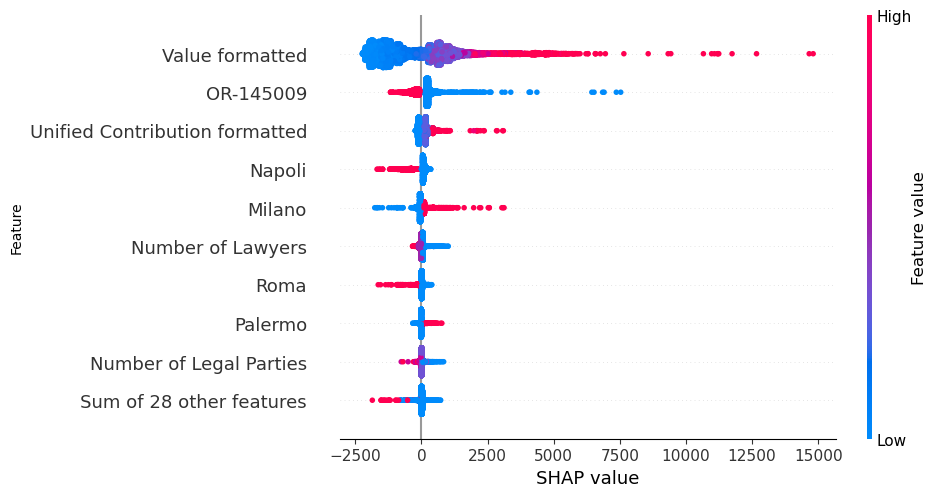

In [18]:
import shap
import matplotlib.pyplot as plt

# Create a shap.Explanation object from the shap_values and X_test variables
explainer = shap.TreeExplainer(rnd_reg)
shap_values = explainer.shap_values(X_test)
shap_exp = shap.Explanation(values=shap_values, 
                            data=X_test, 
                            feature_names=X_test.columns)

# Create a beeswarm plot of the SHAP values
shap.plots.beeswarm(shap_exp, max_display=10, show=False)

# Add labels to the plot
plt.xlabel("SHAP value")
plt.ylabel("Feature")

# Show the plot
plt.show()
